In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
image_size=256
batch_size=32
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Potato Disease/Training/Dataset',shuffle=True,image_size=(image_size,image_size),batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
dataset.class_names

['Early_blight', 'Late_blight', 'healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(image_batch[0].shape)

[[[154. 147. 155.]
  [155. 148. 156.]
  [158. 151. 159.]
  ...
  [153. 147. 159.]
  [159. 153. 165.]
  [164. 158. 170.]]

 [[151. 144. 152.]
  [152. 145. 153.]
  [154. 147. 155.]
  ...
  [164. 158. 170.]
  [166. 160. 172.]
  [166. 160. 172.]]

 [[150. 143. 151.]
  [151. 144. 152.]
  [152. 145. 153.]
  ...
  [167. 161. 173.]
  [165. 159. 171.]
  [161. 155. 167.]]

 ...

 [[129. 116. 125.]
  [104.  91. 100.]
  [111.  98. 107.]
  ...
  [120. 108. 118.]
  [118. 106. 116.]
  [128. 116. 126.]]

 [[101.  88.  97.]
  [ 95.  82.  91.]
  [108.  95. 104.]
  ...
  [112. 100. 110.]
  [127. 115. 125.]
  [145. 133. 143.]]

 [[119. 106. 115.]
  [136. 123. 132.]
  [108.  95. 104.]
  ...
  [123. 111. 121.]
  [134. 122. 132.]
  [137. 125. 135.]]]
(256, 256, 3)


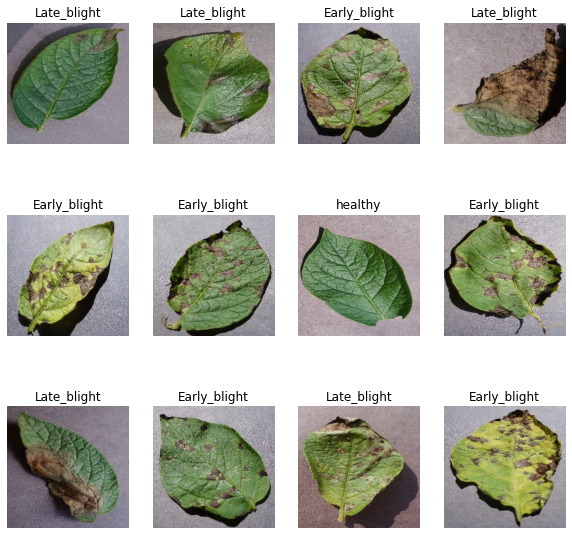

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
epochs = 50
train_size = 0.8
val_size = 0.1
test_size = 0.1

In [9]:
train_ds = dataset.take(int(len(dataset)*train_size))

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_ds = test_ds.take(6)
print(len(val_ds))
test_ds = test_ds.skip(6)
print(len(test_ds))

6
8


In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
CHANNELS = 3
input_shape = (batch_size, image_size, image_size, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 42s 223ms/step - loss: 0.8463 - accuracy: 0.5046 - val_loss: 0.6989 - val_accuracy: 0.6771
Epoch 2/50
54/54 [==============================] - 6s 113ms/step - loss: 0.4972 - accuracy: 0.7726 - val_loss: 0.3126 - val_accuracy: 0.9115
Epoch 3/50
54/54 [==============================] - 6s 113ms/step - loss: 0.3109 - accuracy: 0.8681 - val_loss: 0.2320 - val_accuracy: 0.8906
Epoch 4/50
54/54 [==============================] - 6s 117ms/step - loss: 0.2919 - accuracy: 0.8877 - val_loss: 0.4033 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 6s 115ms/step - loss: 0.2309 - accuracy: 0.9045 - val_loss: 0.1888 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 6s 113ms/step - loss: 0.2142 - accuracy: 0.9138 - val_loss: 0.1699 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 6s 113ms/step - loss: 0.1538 - accuracy: 0.9416 - val_loss: 0.0980 - val_accuracy: 0.9531
Epoch

In [21]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 9s 55ms/step - loss: 3.1216e-04 - accuracy: 1.0000


In [22]:
scores


[0.00031216233037412167, 1.0]

In [23]:
history


In [24]:
history.params


{'epochs': 50, 'steps': 54, 'verbose': 1}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])


list

In [27]:
len(history.history['loss'])


50

In [28]:
history.history['loss'][:5] 

[0.8463279604911804,
 0.49719497561454773,
 0.3109401762485504,
 0.2919304370880127,
 0.2308720499277115]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

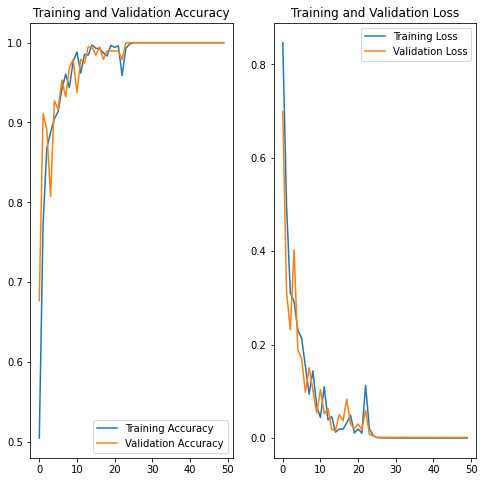

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Late_blight
predicted label: Late_blight


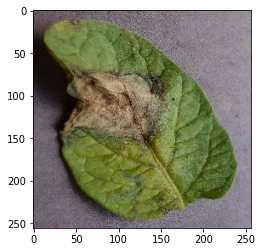

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

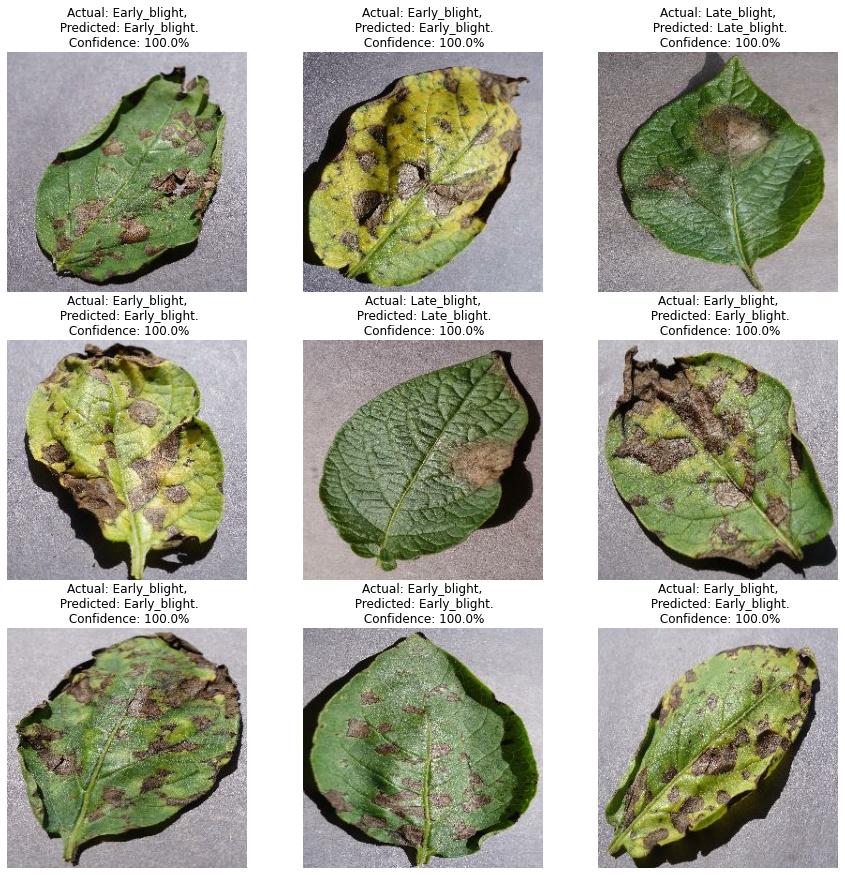

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
model.save("potatoes.h5")